# 1. Integrative Analyses

In [16]:
import polars as pl
import os
import seaborn as sns
%matplotlib inline

In [18]:
pillar_clinvar_df = pl.read_csv("../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_051325_wREVEL.csv", 
                                schema_overrides={"Chrom": pl.String, 'aa_pos': pl.String, 'auth_reported_score': pl.String})
print("Original pillar dataset shape:", pillar_clinvar_df.shape)

## filter the SNP variants only
pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
    (pl.col("consequence").str.contains("sense")) & \
    (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
    (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
).drop_nulls(subset="hgvs_p").with_columns(
    pl.col("hg38_start").cast(pl.Int32).cast(pl.String).alias("nuc_loc")
)

print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.with_columns(
    pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change")
).with_columns(
    pl.concat_str([pl.col("Gene"),pl.col("aa_change")], separator="_").alias("gene_variant")
).sort("gene_variant", "gnomad_MAF", descending=[False,False])

print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])

# display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))
pillar_clinvar_single_aa_df.head()

Original pillar dataset shape: (1063392, 59)
Filtered missense/SNP pillar dataset shape: (128386, 60)
Number of unique gene variants: 61155
Number of unique genes: 33


ID,Dataset,Gene,HGNC_id,Chrom,STRAND,hg19_pos,hg38_start,hg38_end,ref_allele,alt_allele,auth_transcript_id,transcript_pos,transcript_ref,transcript_alt,aa_pos,aa_ref,aa_alt,hgvs_c,hgvs_p,consequence,auth_reported_score,auth_reported_rep_score,auth_reported_func_class,splice_measure,gnomad_MAF,clinvar_sig,clinvar_star,clinvar_date_last_reviewed,nucleotide_or_aa,MaveDB URN (score set),Ensembl_transript_ID,Ref_seq_transcript_ID,Model_system,Assay_type,Phenotype_measured,Phenotype_detail,IGVF_produced,simplified_consequence,Flag,REVEL,Interval 1 name,Interval 1 range,Interval 1 MaveDB class,Interval 2 name,Interval 2 range,Interval 2 MaveDB class,Interval 3 name,Interval 3 range,Interval 3 MaveDB class,Interval 4 name,Interval 4 range,Interval 4 MaveDB class,Interval 5 name,Interval 5 range,Interval 5 MaveDB class,Interval 6 name,Interval 6 range,Interval 6 MaveDB class,nuc_loc,aa_change,gene_variant
str,str,str,f64,str,f64,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""-0.1191""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""","""protein toxicity""","""No""","""missense_variant""",null,0.714,"""Toxic""","""(0.6, Inf)""","""Abnormal""","""Non-toxic""","""(-Inf, 0.4)""","""Normal""",null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Asp""","""ASPA_Ala148Asp"""
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""A""",null,"""443""",null,null,"""148""","""A""","""D""","""c.443C>A""","""p.Ala148Asp""","""missense_variant""","""0.9495""",null,null,"""No""",6.1958e-7,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""","""protein stability""","""No""","""missense_variant""",null,0.714,"""low abundance""","""(-Inf, 0.2)""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Asp""","""ASPA_Ala148Asp"""
"""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA_Grønbæk-Thygesen_2024_tox…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.1248""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-2""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Cell viability""","""protein toxicity""","""No""","""missense_variant""",null,0.679,"""Toxic""","""(0.6, Inf)""","""Abnormal""","""Non-toxic""","""(-Inf, 0.4)""","""Normal""",null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Gly""","""ASPA_Ala148Gly"""
"""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA_Grønbæk-Thygesen_2024_abu…","""ASPA""",756.0,"""17""",1.0,null,3.483509e6,3.483509e6,"""C""","""G""",null,"""443""",null,null,"""148""","""A""","""G""","""c.443C>G""","""p.Ala148Gly""","""missense_variant""","""0.2662""",null,null,"""No""",null,null,null,null,"""aa""","""urn:mavedb:00000657-a-1""","""ENST00000263080.3""","""NM_000049.4""","""immortalized human cells""","""Reporter""","""Fluorescence""","""protein stability""","""No""","""missense_variant""",null,0.679,"""low abundance""","""(-Inf, 0.2)""","""Abnormal""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""3483509""","""Ala148Gly""","""ASPA_Ala148Gly"""

## 1. Imaging Data

In [19]:
PLATEMAP_DIR = "../../2_individual_assay_analyses/imaging/1_inputs/1_snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
BIO_REP_BATCHES = ["2025_01_27_Batch_13", "2025_01_28_Batch_14"]

allele_meta_dict = {}
for batch_id in BIO_REP_BATCHES:
    allele_meta_df = pl.DataFrame()
    for platemap in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)):
        platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
        allele_meta_df = pl.concat([allele_meta_df, 
                                    platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                    how="diagonal_relaxed").sort("plate_map_name")
        allele_meta_df = allele_meta_df.with_columns(pl.col("plate_map_name").str.split('_').list.get(0).alias("plate_map"))
    allele_meta_dict[batch_id] = allele_meta_df

In [20]:
allele_meta_dict["2025_01_27_Batch_13"].filter(pl.col("node_type")=="allele").unique(subset=["symbol","gene_allele"])

plate_map_name,well_position,symbol,gene_allele,imaging_well,imaging_plate_R1,imaging_plate_R2,node_type,orf_id_wt,ccsb_mutation_id,nt_change_cdna,aa_change,allele_set,imaging_plate,batch1,batch2,clone_ID,hgmd_ID,clinvar_allele_ID,clinvar_clinical_significance,vector,notes,plate,quad,c96,r96,r384,c384,r384_letter,plate_map
str,str,str,str,str,str,str,str,f64,str,str,str,f64,f64,f64,f64,str,str,str,str,f64,str,i64,i64,i64,i64,i64,i64,str,str
"""B13A7A8P1_R1""","""H13""","""KRAS""","""KRAS_Ile36Met""","""H13""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",3084.0,"""CCSBVarC006095""","""108A>G""","""Ile36Met""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,3,7,4,8,13,"""H""","""B13A7A8P1"""
"""B13A7A8P1_R1""","""O12""","""F9""","""F9_Asp110Asn""","""O12""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",52861.0,"""CCSBVarC004376""","""328G>A""","""Asp110Asn""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,2,6,8,15,12,"""O""","""B13A7A8P1"""
"""B13A7A8P1_R1""","""I19""","""BRCA1""","""BRCA1_Phe558Ser""","""I19""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",14613.0,"""CCSBVarC013021""","""1673T>C""","""Phe558Ser""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,10,5,9,19,"""I""","""B13A7A8P1"""
"""B13A7A8P1_R1""","""L01""","""FARS2""","""FARS2_Asn280Ser""","""L01""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",12653.0,"""CCSBVarC011867""","""839A>G""","""Asn280Ser""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,3,1,6,12,1,"""L""","""B13A7A8P1"""
"""B13A7A8P1_R1""","""M21""","""BRCA1""","""BRCA1_His239Arg""","""M21""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",14613.0,"""CCSBVarC013119""","""716A>G""","""His239Arg""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,1,11,7,13,21,"""M""","""B13A7A8P1"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""B13A7A8P1_R1""","""P12""","""NF2""","""NF2_Leu315Pro""","""P12""","""B13A7A8P1_R1""","""B14A7A8P1_R2""","""allele""",3697.0,"""CCSBVarC015533""","""944T>C""","""Leu315Pro""",7.0,1.0,13.0,14.0,null,null,null,null,527.0,null,1,4,6,8,16,12,"""P""","""B13A7A8P1"""
"""B13A7A8P2_R1""","""D23""","""CCM2""","""CCM2_Ser393Gly""","""D23""","""B13A7A8P2_R1""","""B14A7A8P2_R2""","""allele""",3928.0,"""CCSBVarC038816""","""1177A>G""","""Ser393Gly""",8.0,2.0,13.0,14.0,null,null,null,null,527.0,null,2,3,12,2,4,23,"""D""","""B13A7A8P2"""
"""B13A7A8P2_R1""","""M20""","""CCM2""","""CCM2_Ala98Pro""","""M20""","""B13A7A8P2_R1""","""B14A7A8P2_R2""","""allele""",3928.0,"""CCSBVarC038643""","""292G>C""","""Ala98Pro""",8.0,2.0,13.0,14.0,null,null,null,null,527.0,null,2,2,10,7,13,20,"""M""","""B13A7A8P2"""


In [25]:
var_img_pillar_df = allele_meta_dict["2025_01_27_Batch_13"].filter(pl.col("node_type")=="allele").unique(subset=["symbol","gene_allele"]).join(
    pillar_clinvar_single_aa_df,
    left_on="gene_allele",
    right_on="gene_variant"
)
print("VarChAMP Imaged Variants overlapped with Pillar:", var_img_pillar_df.shape[0])

VarChAMP Imaged Variants overlapped with Pillar: 394


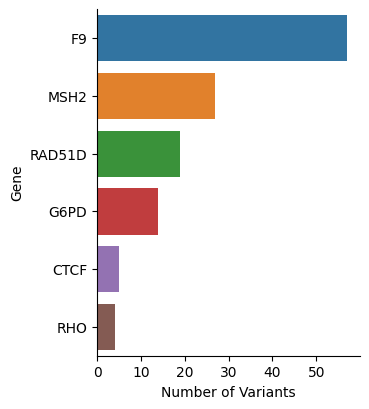

In [26]:
g = sns.catplot(data=var_img_pillar_df.unique(subset="gene_allele").group_by("Gene").len().sort(by="len", descending=True).rename({"len":"Number of Variants"}).to_pandas(), 
                x="Number of Variants", y="Gene", kind="bar", height=4, aspect=.9)